In [1]:
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

2.9.2


In [2]:
DATASET_DIR= "./data smol"
EPOCHS = 20
BATCH_SIZE = 32
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_SHAPE=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)

Load Dataset

In [55]:
from keras.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator(
#   # shear_range=0.3,
#   # zoom_range=0.3,
#   # horizontal_flip=True,
#   # vertical_flip=True,
#   # rotation_range=180,
#   # fill_mode='nearest',
#   validation_split=0.25,
#   seed=69,
# )

# train_ds = train_datagen.flow_from_directory(
#   F"{DATASET_DIR}",
#   # batch_size=BATCH_SIZE,
#   target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
#   # class_mode='categorical',
#   subset='training'
# )

# val_datagen = ImageDataGenerator()

# val_ds = train_datagen.flow_from_directory(
#   F"{DATASET_DIR}",
#   # batch_size=BATCH_SIZE,
#   target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
#   # class_mode='categorical',
#   subset='validation'
# )

train_ds = tf.keras.utils.image_dataset_from_directory(
  F"{DATASET_DIR}",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  F"{DATASET_DIR}",
  validation_split=0.2,
  subset="validation",
  seed=456,
  image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE,
)

Found 16000 files belonging to 4 classes.
Using 12800 files for training.
Found 16000 files belonging to 4 classes.
Using 3200 files for validation.


preview data

['Bacterial leaf blight', 'Brown spot', 'Healthy', 'Leaf smut']


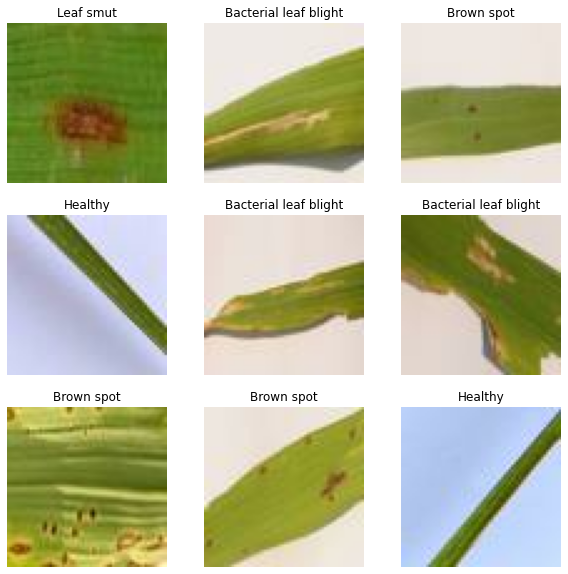

In [56]:
class_names = train_ds.class_names
print(class_names)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# for image_batch, labels_batch in train_ds:
#   print(image_batch.shape)
#   print(labels_batch.shape)
#   break

Prefetch dataset

In [57]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Build The CNN

In [70]:
reshape_and_rescale = keras.Sequential([
    keras.layers.Rescaling(1./255),
])

data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomTranslation(0.2, 0.2),
    keras.layers.RandomZoom(0.2),
    keras.layers.RandomBrightness(0.4),
    keras.layers.RandomContrast(0.4),
])

model = keras.models.Sequential([
    keras.layers.Input(shape=IMAGE_SHAPE),

    reshape_and_rescale,
    data_augmentation,

    keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),

    keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),

    keras.layers.Conv2D(128, 3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),

    keras.layers.Dropout(0.2),

    keras.layers.Flatten(),

    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation="relu"),

    keras.layers.Dense(4, activation="softmax")
])


model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_21 (Sequential)  (None, 64, 64, 3)         0         
                                                                 
 sequential_22 (Sequential)  (None, 64, 64, 3)         0         
                                                                 
 conv2d_48 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                

Training

In [64]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    # steps_per_epoch=train_ds.samples/train_ds.batch_size,
    # batch_size=BATCH_SIZE,
    # validation_steps=validation_ds.samples/validation_ds.batch_size
)

Epoch 1/20
400/400 [==============================] - 11s 25ms/step - loss: 0.5011 - sparse_categorical_accuracy: 0.7792 - val_loss: 0.2377 - val_sparse_categorical_accuracy: 0.9013
Epoch 2/20
400/400 [==============================] - 10s 24ms/step - loss: 0.1558 - sparse_categorical_accuracy: 0.9392 - val_loss: 0.0681 - val_sparse_categorical_accuracy: 0.9775
Epoch 3/20
400/400 [==============================] - 10s 24ms/step - loss: 0.0763 - sparse_categorical_accuracy: 0.9709 - val_loss: 0.0685 - val_sparse_categorical_accuracy: 0.9741
Epoch 4/20
400/400 [==============================] - 10s 25ms/step - loss: 0.0555 - sparse_categorical_accuracy: 0.9798 - val_loss: 0.0579 - val_sparse_categorical_accuracy: 0.9762
Epoch 5/20
400/400 [==============================] - 10s 24ms/step - loss: 0.0402 - sparse_categorical_accuracy: 0.9841 - val_loss: 0.0117 - val_sparse_categorical_accuracy: 0.9959
Epoch 6/20
400/400 [==============================] - 10s 25ms/step - loss: 0.0165 - spars

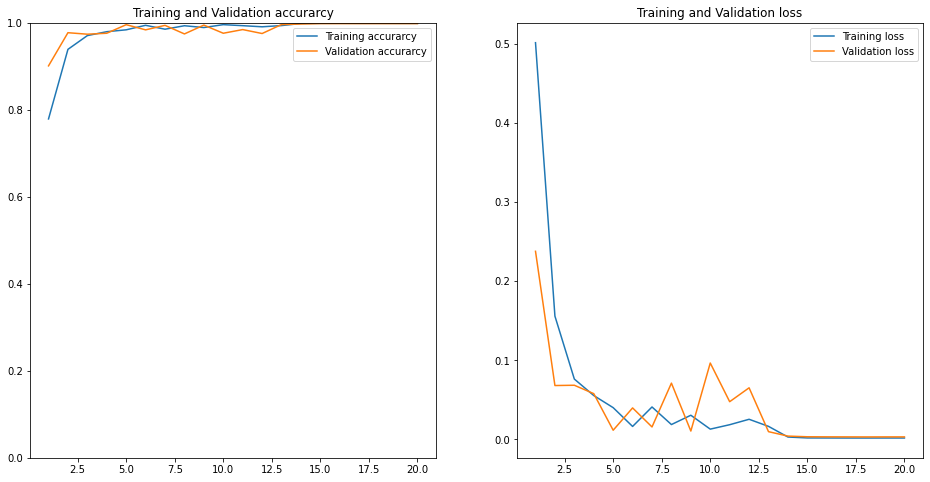

In [65]:
from matplotlib import pyplot as plt

acc = history.history["sparse_categorical_accuracy"]
val_acc = history.history["val_sparse_categorical_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.ylim((0, 1))
plt.plot(epochs, acc, label="Training accurarcy")
plt.plot(epochs, val_acc, label="Validation accurarcy")
plt.title("Training and Validation accurarcy")
plt.legend()

# Train and validation loss
plt.subplot(1, 2, 2)

plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.title("Training and Validation loss")
plt.legend()
plt.show()

Prediction

In [102]:
print(train_ds.class_indices)

{'Bacterial leaf blight': 0, 'Brown spot': 1, 'Healthy': 2, 'Leaf smut': 3}


In [74]:
import numpy as np

img = keras.utils.load_img(
  f"{DATASET_DIR}/test/Leaf smut/smut-_0_2488.jpg",
  # target_size=(IMAGE_HEIGHT, IMAGE_WIDTH)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)

for prediction in predictions:
  score = tf.nn.softmax(prediction)
  # class_names = train_ds.class_names
  print(
      100*score
  )

1/1 [==============================] - 0s 11ms/step
tf.Tensor([21.196209 21.19473  57.609062], shape=(3,), dtype=float32)


In [11]:
def predict(type):
  img = keras.utils.load_img(
    f"{DATASET_DIR}/test/Leaf smut/smut-_0_2488.jpg",
    # target_size=(128, 128)
  )

  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])


  path = src
  img_matrix = convert_image_to_array(path)
  toBePredictedImage = np.expand_dims(img_matrix, axis=0)
  
  result = model.predict(toBePredictedImage)
  predictedClass = [np.argmax(element) for element in result]
  image_folder = path[9:10]
  boolResult = False
  if str(image_folder) == str(predictedClass[0]):
      boolResult = True
  # print(f"\nPredicted value for {path} --- Predicted Class {predictedClass} --- Result {result} --- Correct???? {boolResult}")
  return boolResult